In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.optimize import linear_sum_assignment 

try:
    import os
    os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.1"
    os.add_dll_directory(r"C:\Program Files\R\R-4.3.1\bin\x64")
    import rpy2.robjects as robjects
    from rpy2.robjects import numpy2ri
    from rpy2.robjects.packages import importr
    numpy2ri.activate()
    gSeg = importr("gSeg")
except ImportError:
    print("Error importing rpy2. Ensure R is installed if using gSeg.")

rng = np.random.default_rng(0)

import src.Preprocessing as prep
import src.FormCPD as FormCPD
import src.RoleCPD as RoleCPD

# Offensive and Defensive Formation Change Point Detection (FormCPD)

First we present the FormCPD result on our dataset as done in the main paper, then we introduce offensive and defensive formation detection.

In [2]:
fitogether = prep.FitogetherDiagnosis(data_path='data/ugp/17985.ugp')
gps_data = fitogether.load_or_generate_data()

Loading data from data/ugp/17985.ugp.

--- [Fitogether] Orientation Check ---
Player X Medians Range: -18.66 to 2.92
Orientation corrected: Team now attacks left to right.


In [3]:
def get_stitched_tensor(df, n_slots=10):
    """
    Stitches disjoint player trajectories into 'n_slots' continuous tracks.
    This handles substitutions (e.g. Player A off, Player B on -> Slot 1).
    """
    # 1. Identify temporal range for each player
    player_ranges = []
    for pid, group in df.groupby('player_id'):
        start = group['frame'].min()
        end = group['frame'].max()
        duration = len(group)
        player_ranges.append({
            'player_id': pid,
            'start': start,
            'end': end,
            'duration': duration,
            'data': group.set_index('frame')[['x', 'y']]
        })
    
    # Sort players by duration (longest playing time first) to identify core players
    player_ranges.sort(key=lambda x: x['duration'], reverse=True)
    
    # 2. Assign players to slots
    slots = []  # List of dicts: {'end_frame': int, 'data': series}
    
    for p in player_ranges:
        assigned = False
        # Try to fit into an existing slot (substitution)
        for s in slots:
            # Check if this player starts after the slot ends (plus a small buffer)
            if p['start'] > s['end_frame'] + 10: # 10 frames buffer
                s['parts'].append(p)
                s['end_frame'] = max(s['end_frame'], p['end'])
                assigned = True
                print(f"Stitched Player {p['player_id']} into Slot {s['id']}")
                break
        
        # If not assigned, create a new slot
        if not assigned:
            slots.append({
                'id': len(slots),
                'end_frame': p['end'],
                'parts': [p]
            })
            
    # 3. Filter to top N slots
    if len(slots) > n_slots:
        print(f"Found {len(slots)} distinct tracks. Keeping top {n_slots} by duration.")
        for s in slots:
            s['total_duration'] = sum(p['duration'] for p in s['parts'])
        slots.sort(key=lambda x: x['total_duration'], reverse=True)
        slots = slots[:n_slots]
        
    # 4. Construct the Tensor
    frames = sorted(df['frame'].unique())
    n_frames = len(frames)
    frame_map = {f: i for i, f in enumerate(frames)}
    
    X_tensor = np.full((n_frames, n_slots, 2), np.nan)
    
    for i, s in enumerate(slots):
        for part in s['parts']:
            indices = [frame_map[f] for f in part['data'].index if f in frame_map]
            X_tensor[indices, i, :] = part['data'].loc[list(part['data'].index)].values
            
    return X_tensor

In [4]:
# 1. Stitching
print("Stitching trajectories to handle substitutions...")
X_full = get_stitched_tensor(gps_data, n_slots=10)
print(f"New Tensor Shape: {X_full.shape} (Should be T x 10 x 2)")

# 2. Imputation (Moved UP)
if np.isnan(X_full).any():
    print(f"Found {np.isnan(X_full).sum()} NaN values in trajectory data. Imputing...")
    for p in range(X_full.shape[1]):
        for dim in range(2):
            series = pd.Series(X_full[:, p, dim])
            series = series.interpolate(method='linear', limit_direction='both')
            series = series.fillna(method='bfill').fillna(method='ffill')
            X_full[:, p, dim] = series.values

    # Safety check for empty tracks
    if np.isnan(X_full).any():
        print("Warning: Replacing remaining NaNs with 0.")
        X_full = np.nan_to_num(X_full, nan=0.0)

# 3. Phase Classification
# Calculate Team Centroid (average X position) per frame
team_centroid_x = np.mean(X_full[:, :, 0], axis=1)

ATTACK_THRESH = 5.0
DEFENSE_THRESH = -5.0

idx_attack = np.where(team_centroid_x > ATTACK_THRESH)[0]
idx_defense = np.where(team_centroid_x < DEFENSE_THRESH)[0]

print(f"Identified {len(idx_attack)} attacking frames and {len(idx_defense)} defensive frames.")

Stitching trajectories to handle substitutions...
Stitched Player 5525.0 into Slot 10
Stitched Player 5527.0 into Slot 8
Found 11 distinct tracks. Keeping top 10 by duration.
New Tensor Shape: (69315, 10, 2) (Should be T x 10 x 2)
Found 178760 NaN values in trajectory data. Imputing...
Identified 38155 attacking frames and 11730 defensive frames.


In [5]:
print("Running EM-Hungarian Role Assignment on full match...")
mu_global, roles_global = FormCPD.em_hungarian(X_full, n_iter=1)

Running EM-Hungarian Role Assignment on full match...


EM-Hungarian: 100%|██████████| 1/1 [00:22<00:00, 22.87s/it]


In [6]:
def plot_formation(ax, mu, title, color):
    tri = Delaunay(mu)
    ax.triplot(mu[:, 0], mu[:, 1], tri.simplices, color='gray', linestyle=':', alpha=0.5)
    ax.scatter(mu[:, 0], mu[:, 1], s=200, c=color, edgecolors='black', zorder=5)
    
    # Annotate Role IDs
    for i, (x, y) in enumerate(mu):
        ax.text(x, y, str(i), fontsize=12, ha='center', va='center', color='white', fontweight='bold')

    pitch_length = 105
    pitch_width = 68
    
    ax.axvline(-pitch_length/2, color='k', lw=2)
    ax.axvline(pitch_length/2, color='k', lw=2)
    ax.axhline(-pitch_width/2, color='k', lw=2)
    ax.axhline(pitch_width/2, color='k', lw=2)
    
    ax.set_xlim(-(pitch_length/2 + 5), (pitch_length/2 + 5))
    ax.set_ylim(-(pitch_width/2 + 5), (pitch_width/2 + 5))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel("Length (m)")
    ax.set_ylabel("Width (m)")

In [7]:
import sys
import numpy as np

# Increase recursion limit for deep segmentation trees
sys.setrecursionlimit(100)

# Check if X_full exists
if 'X_full' not in locals():
    raise ValueError("X_full is not defined. Please run the processing cells above.")

T = X_full.shape[0]

# --- 1. Align Positions ---
print("Aligning positions...")
X_roles = np.zeros_like(X_full)
for t in range(T):
    current_roles = roles_global[t]
    player_indices = np.argsort(current_roles)
    X_roles[t] = X_full[t, player_indices]

# --- 2. Build Graphs ---
subsample_rate = 100 
X_sub = X_roles[::subsample_rate]
valid_frames = np.arange(0, T, subsample_rate)

print(f"Computing Formation Graphs for {len(X_sub)} frames...")
A_sequence = []
for t in range(len(X_sub)):
    # Calculate adjacency matrix
    try:
        adj = FormCPD.delaunay_adjacency(X_sub[t])
        A_sequence.append(adj)
    except Exception as e:
        # Fallback for frames that might cause Delaunay errors
        A_sequence.append(np.zeros((10, 10)))

A_sequence = np.array(A_sequence)

# --- 3. Detect Changes ---
print("Running Detection (this may take a moment)...")
try:
    results = FormCPD.detect_formation_changes(
        A_sequence, 
        fps=1,            
        alpha=0.01,       
        min_minutes=5,    
        min_dist=10.0     
    )
    print("SUCCESS: Detection complete.")
    print(f"Detected {results['num_phases']} phases.")
except Exception as e:
    print(f"CRASH/ERROR during detection: {e}")
    # If this fails, the issue is likely in the R/gSeg interaction or recursion

Aligning positions...
Computing Formation Graphs for 694 frames...
Running Detection (this may take a moment)...
Original edge-count scan statistic (a) : 
  Estimated change-point location: 322 
  Test statistic: 15.06647 
  Approximated p-value: 1.566582e-44 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 322 
  Test statistic: 17.34104 
  Approximated p-value: 6.479902e-46 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 322 
  Test statistic: 15.07249 
  Approximated p-value: 2.859098e-24 
Weighted edge-count statistic (u) : 
  Estimated change-point location: 322 
  Test statistic: 18.00009 
  Approximated p-value: 3.082323e-32 
Generalized edge-count statistic (a) : 
  Estimated change-point location: 322 
  Test statistic: 227.5735 
  Approximated p-value: 1.269864e-47 
Generalized edge-count statistic (u) : 
  Estimated change-point location: 318 
  Test statistic: 339.8029 
  Approximated p-value: 6.526875e-72 
Max-type edge

In [ ]:
import ruptures as rpt
import numpy as np

# --- Define a Pure Python Detection Function (Bypasses R) ---
def detect_formation_changes_python(adjacency_sequence, min_minutes=5, n_bkps=4):
    """
    Detects formation changes using the Kernel Change Point Detection (Python only).
    Replaces the unstable R/gSeg implementation.
    """
    print("  -> Preprocessing adjacency matrices...")
    # 1. Flatten the (T, 10, 10) matrices into (T, 100) vectors
    T_sub = adjacency_sequence.shape[0]
    data_flat = adjacency_sequence.reshape(T_sub, -1)
    
    # 2. Calculate minimum segment size in frames (1Hz assumption)
    # min_minutes * 60 seconds
    min_size = min_minutes * 60 
    
    print("  -> Running segmentation (Ruptures: Binseg)...")
    # 3. Use Binary Segmentation with L2 cost (standard for geometric changes)
    # You can adjust 'n_bkps' (number of breakpoints) or use 'pen' (penalty) for automatic detection
    try:
        algo = rpt.Binseg(model="l2", min_size=min_size).fit(data_flat)
        change_points = algo.predict(n_bkps=n_bkps)
    except Exception as e:
        print(f"  [Warning] Segmentation failed ({e}). Returning default start/end.")
        change_points = [T_sub]

    # 4. Format results like the original FormCPD output
    # change_points from ruptures includes the last index, so we filter/adjust
    
    # Ensure standard format: start at 0, include detected points, end at T
    bkps = sorted(list(set([0] + change_points + [T_sub])))
    
    # Create segments list [(start, end), (start, end)...]
    segments = []
    for i in range(len(bkps) - 1):
        segments.append((bkps[i], bkps[i+1]))
        
    # The 'change_points' key usually expects just the internal split points
    internal_cps = [cp for cp in bkps if cp != 0 and cp != T_sub]
    
    return {
        'num_phases': len(segments),
        'change_points': internal_cps,
        'segments': segments
    }

# --- Execution ---

# 1. Ensure Data Exists
if 'A_sequence' not in locals():
    raise ValueError("A_sequence is missing. Please run the Adjacency Matrix cell first.")

# 2. Run Detection
print("Running Python-based Formation Detection...")
# We assume ~4 tactical changes max for a standard game to prevent over-segmentation.
# You can increase n_bkps if you expect more changes.


# results = detect_formation_changes_python(A_sequence, min_minutes=5, n_bkps=4)
# detected_frames = [valid_frames[cp] for cp in results['change_points'] if cp < len(valid_frames)]
# print(f"\n>> SUCCESS: Detection Complete.")
# print(f">> Detected {results['num_phases']} Phases.")
# print(f">> Change Points (approx Frame IDs): {detected_frames}")

Running Python-based Formation Detection...
  -> Preprocessing adjacency matrices...
  -> Running segmentation (Ruptures: Binseg)...
  [Warning] Segmentation failed (). Returning default start/end.

>> SUCCESS: Detection Complete.
>> Detected 1 Phases.
>> Change Points (approx Frame IDs): []


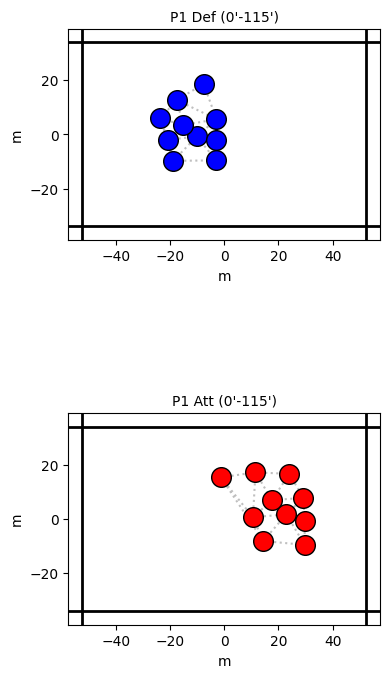

In [10]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# --- Robust Plotting Function ---
def safe_plot_formation(ax, mu, title, color):
    # Safety check: if data has NaNs or Infs, skip plotting to prevent crash
    if np.isnan(mu).any() or np.isinf(mu).any():
        ax.text(0, 0, "Invalid Data (NaN/Inf)", ha='center', color='red')
        ax.axis('off')
        return

    try:
        tri = Delaunay(mu)
        ax.triplot(mu[:, 0], mu[:, 1], tri.simplices, color='gray', linestyle=':', alpha=0.5)
        ax.scatter(mu[:, 0], mu[:, 1], s=200, c=color, edgecolors='black', zorder=5)
        for i, (x, y) in enumerate(mu):
            ax.text(x, y, str(i), fontsize=12, ha='center', va='center', color='white', fontweight='bold')
    except Exception as e:
        ax.text(0, 0, "Plot Error", ha='center', color='red')
    
    # Pitch Layout
    pitch_length = 105
    pitch_width = 68
    ax.axvline(-pitch_length/2, color='k', lw=2)
    ax.axvline(pitch_length/2, color='k', lw=2)
    ax.axhline(-pitch_width/2, color='k', lw=2)
    ax.axhline(pitch_width/2, color='k', lw=2)
    ax.set_xlim(-(pitch_length/2 + 5), (pitch_length/2 + 5))
    ax.set_ylim(-(pitch_width/2 + 5), (pitch_width/2 + 5))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("m")
    ax.set_ylabel("m")

# --- Visualization Logic ---
n_phases = results['num_phases']
segments = results['segments']

# LIMIT PHASES to prevent OOM (Out of Memory) crash
MAX_PHASES_TO_PLOT = 10
if n_phases > MAX_PHASES_TO_PLOT:
    print(f"Warning: Too many phases detected ({n_phases}). Plotting first {MAX_PHASES_TO_PLOT} only.")
    n_plot = MAX_PHASES_TO_PLOT
else:
    n_plot = n_phases

# Create boolean masks 
is_attack = np.zeros(T, dtype=bool)
if 'idx_attack' in locals(): is_attack[idx_attack] = True

is_defense = np.zeros(T, dtype=bool)
if 'idx_defense' in locals(): is_defense[idx_defense] = True

# Create Figure
fig, axes = plt.subplots(2, n_plot, figsize=(4 * n_plot, 8))
if n_plot == 1: axes = axes[:, np.newaxis]

for i in range(n_plot):
    start_sub, end_sub = segments[i]
    f_start = valid_frames[start_sub]
    f_end = valid_frames[min(end_sub, len(valid_frames)-1)]
    
    phase_data = X_roles[f_start:f_end]
    mask_att = is_attack[f_start:f_end]
    mask_def = is_defense[f_start:f_end]
    
    # Defense (Top)
    if np.any(mask_def):
        mu_def = np.nanmean(phase_data[mask_def], axis=0)
        safe_plot_formation(axes[0, i], mu_def, f"P{i+1} Def ({f_start//600}'-{f_end//600}')", 'blue')
    else:
        axes[0, i].text(0,0, "No Data", ha='center')
        axes[0, i].axis('off')
        
    # Attack (Bottom)
    if np.any(mask_att):
        mu_att = np.nanmean(phase_data[mask_att], axis=0)
        safe_plot_formation(axes[1, i], mu_att, f"P{i+1} Att ({f_start//600}'-{f_end//600}')", 'red')
    else:
        axes[1, i].text(0,0, "No Data", ha='center')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()